In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.utils as vutils

import glob
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.files = glob.glob(root_dir+"/*")
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

In [3]:
dataroot = "../input/animefacedataset/images"
img_size=64
batch_size = 32
dataset = CustomDataset(root_dir=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((img_size, img_size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
class EqualLR:
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * sqrt(2 / fan_in)

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module

In [5]:
class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, x):
        return self.linear(x)

In [6]:
class EqualConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)

In [7]:
class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, x):
        batch = x.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)
        return out

In [8]:
class NoiseInjection(nn.Module):
    def __init__(self, channel):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1, channel, 1, 1))

    def forward(self, image, noise):
        return image + self.weight * noise

In [9]:
class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, in_channel, style_dim):
        super().__init__()

        self.norm = nn.InstanceNorm2d(in_channel)
        self.style = nn.Linear(style_dim, in_channel * 2)
        self.style.bias.data[:in_channel] = 1
        self.style.bias.data[in_channel:] = 0

    def forward(self, input, style):
        style = self.style(style).unsqueeze(2).unsqueeze(3)
        gamma, beta = style.chunk(2, 1)

        out = self.norm(input)
        out = gamma * out + beta

        return out

In [10]:
class BlurFunctionBackward(Function):
    @staticmethod
    def forward(ctx, grad_output, kernel, kernel_flip):
        ctx.save_for_backward(kernel, kernel_flip)

        grad_input = F.conv2d(
            grad_output, kernel_flip, padding=1, groups=grad_output.shape[1]
        )

        return grad_input

    @staticmethod
    def backward(ctx, gradgrad_output):
        kernel, kernel_flip = ctx.saved_tensors

        grad_input = F.conv2d(
            gradgrad_output, kernel, padding=1, groups=gradgrad_output.shape[1]
        )

        return grad_input, None, None


class BlurFunction(Function):
    @staticmethod
    def forward(ctx, input, kernel, kernel_flip):
        ctx.save_for_backward(kernel, kernel_flip)

        output = F.conv2d(input, kernel, padding=1, groups=input.shape[1])

        return output

    @staticmethod
    def backward(ctx, grad_output):
        kernel, kernel_flip = ctx.saved_tensors

        grad_input = BlurFunctionBackward.apply(grad_output, kernel, kernel_flip)

        return grad_input, None, None


blur = BlurFunction.apply


class Blur(nn.Module):
    def __init__(self, channel):
        super().__init__()

        weight = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32)
        weight = weight.view(1, 1, 3, 3)
        weight = weight / weight.sum()
        weight_flip = torch.flip(weight, [2, 3])

        self.register_buffer('weight', weight.repeat(channel, 1, 1, 1))
        self.register_buffer('weight_flip', weight_flip.repeat(channel, 1, 1, 1))

    def forward(self, input):
        return blur(input, self.weight, self.weight_flip)

In [11]:
class StyledConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size=3,
        padding=1,
        style_dim=512,
        initial=False,
        upsample=False
    ):
        super().__init__()

        if initial:
            self.conv1 = ConstantInput(in_channel)

        else:
            if upsample:
                self.conv1 = nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='nearest'),
                    EqualConv2d(
                        in_channel, out_channel, kernel_size, padding=padding
                    ),
                    Blur(out_channel),
                )
            else:
                self.conv1 = EqualConv2d(
                    in_channel, out_channel, kernel_size, padding=padding
                )

        self.noise1 = NoiseInjection(out_channel)
        self.adain1 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu1 = nn.LeakyReLU(0.2)

        self.conv2 = EqualConv2d(out_channel, out_channel, kernel_size, padding=padding)
        self.noise2 = NoiseInjection(out_channel)
        self.adain2 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu2 = nn.LeakyReLU(0.2)

    def forward(self, x, style, noise):
        out = self.conv1(x)
        out = self.noise1(out, noise)
        out = self.lrelu1(out)
        out = self.adain1(out, style)

        out = self.conv2(out)
        out = self.noise2(out, noise)
        out = self.lrelu2(out)
        out = self.adain2(out, style)

        return out

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim=512, n_linear=5):
        super(Generator, self).__init__()
        layers = []
        for i in range(n_linear):
            layers.append(EqualLinear(z_dim, z_dim))
            layers.append(nn.LeakyReLU(0.2))
        self.style = nn.Sequential(*layers)
        self.progression = nn.ModuleList(
            [
              StyledConvBlock(512, 512, 3, 1, initial=True),
              StyledConvBlock(512, 256, 3, 1, upsample=True),
              StyledConvBlock(256, 128, 3, 1, upsample=True),
              StyledConvBlock(128, 64, 3, 1, upsample=True),
              StyledConvBlock(64, 32, 3, 1, upsample=True),
            ]
        )
        self.to_rgb = EqualConv2d(32, 3, 1)

    def forward(self, x, noise=None, step=0):
        batch = x.size(0)
        if noise is None:
            noise = []
            for i in range(step + 1):
                size = 4 * 2 ** i
                noise.append(torch.randn(batch, 1, size, size, device=x[0].device))
        x = x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)
        styles = self.style(x)
        out = noise[0]
        for i, conv in enumerate(self.progression):
            out = self.progression[i](out, styles, noise[i])
        return self.to_rgb(out)

In [13]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        padding,
        downsample=False,
        fused=False
    ):
        super().__init__()
        self.conv1 = nn.Sequential(
            EqualConv2d(in_channel, out_channel, kernel_size, padding=padding),
            nn.LeakyReLU(0.2),
        )

        if downsample:
            self.conv2 = nn.Sequential(
                Blur(out_channel),
                EqualConv2d(out_channel, out_channel, kernel_size, padding=padding),
                nn.AvgPool2d(2),
                nn.LeakyReLU(0.2),
            )

        else:
            self.conv2 = nn.Sequential(
                EqualConv2d(out_channel, out_channel, kernel_size, padding=padding),
                nn.LeakyReLU(0.2),
            )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        return out

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            EqualConv2d(3, 16, 1), 
            nn.LeakyReLU(0.2),
            ConvBlock(16, 32, 3, 1, downsample=True),
            ConvBlock(32, 64, 3, 1, downsample=True),
            ConvBlock(64, 128, 3, 1, downsample=True),
            ConvBlock(128, 256, 3, 1, downsample=True),
            EqualConv2d(256, 256, 4, padding=0),
            nn.LeakyReLU(0.2),
        )
        self.linear = nn.Linear(256, 1)
    
    def forward(self, x):
        x = self.conv(x).reshape(x.size(0), -1)
        return torch.sigmoid(self.linear(x))

tensor([[0.7087],
        [0.8231],
        [0.8083],
        [0.8034],
        [0.7327],
        [0.6893],
        [0.7239],
        [0.6864],
        [0.7164],
        [0.7191],
        [0.7638],
        [0.8105],
        [0.7319],
        [0.7083],
        [0.7344],
        [0.7763]], device='cuda:0', grad_fn=<SigmoidBackward0>)

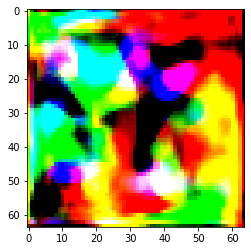

In [15]:
import math
from math import sqrt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
z = torch.randn(16, 512).to(device)
step = int(math.log(64,2))-2
out = G(z, step=step)

plt.imshow(out[0].permute([1,2,0]).detach().cpu().numpy())
D = Discriminator().to(device)
D(out)

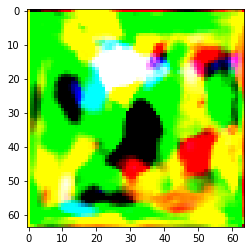

In [16]:
plt.imshow(out[1].permute([1,2,0]).detach().cpu().numpy())

In [17]:
sum(p.numel() for p in D.parameters())

2225153

In [18]:
sum(p.numel() for p in G.parameters())

8069987

In [19]:
num_epochs=40
lr = 3e-4
step = int(math.log(64,2))-2
real_label = 1.
fake_label = 0.

criterion = nn.BCELoss()
dim_z = 512

optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, dim_z, device=device)

In [20]:
iters = 0
G_losses = []
D_losses = []
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, dim_z, device=device)
        # Generate fake image batch with G
        fake = G(noise, step=step)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise, step=step).detach().cpu()
        iters += 1

[0/40][0/1987]	Loss_D: 2.0139	Loss_G: 0.3905	D(x): 0.5883	D(G(z)): 0.7599 / 0.6812
[0/40][50/1987]	Loss_D: 1.2823	Loss_G: 0.9138	D(x): 0.4680	D(G(z)): 0.4054 / 0.4035
[0/40][100/1987]	Loss_D: 1.2509	Loss_G: 0.8204	D(x): 0.5190	D(G(z)): 0.4447 / 0.4458
[0/40][150/1987]	Loss_D: 1.2238	Loss_G: 0.7875	D(x): 0.5673	D(G(z)): 0.4728 / 0.4654
[0/40][200/1987]	Loss_D: 0.7832	Loss_G: 1.5851	D(x): 0.6241	D(G(z)): 0.2465 / 0.2606
[0/40][250/1987]	Loss_D: 0.9967	Loss_G: 1.5224	D(x): 0.5792	D(G(z)): 0.3185 / 0.2788
[0/40][300/1987]	Loss_D: 1.1255	Loss_G: 1.0984	D(x): 0.6630	D(G(z)): 0.4490 / 0.3902
[0/40][350/1987]	Loss_D: 0.9796	Loss_G: 1.0449	D(x): 0.6747	D(G(z)): 0.4081 / 0.3968
[0/40][400/1987]	Loss_D: 0.9125	Loss_G: 1.1807	D(x): 0.7406	D(G(z)): 0.4173 / 0.3886
[0/40][450/1987]	Loss_D: 0.8248	Loss_G: 1.6086	D(x): 0.7205	D(G(z)): 0.3353 / 0.2898
[0/40][500/1987]	Loss_D: 0.5212	Loss_G: 2.3842	D(x): 0.8119	D(G(z)): 0.2180 / 0.1786
[0/40][550/1987]	Loss_D: 1.1734	Loss_G: 1.4508	D(x): 0.8280	D(G(z)):

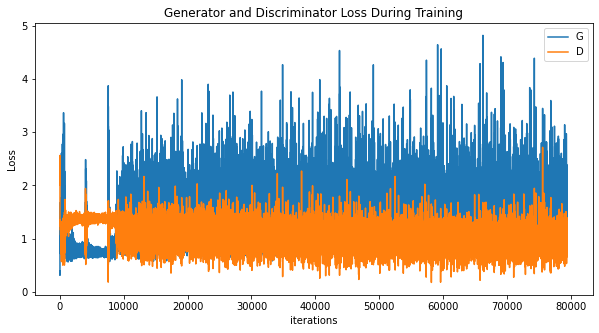

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

tensor([[[-0.1063,  0.1711,  0.2418,  ..., -0.1587,  0.1313,  0.2881],
         [-0.1348,  0.0952,  0.3110,  ..., -0.2375,  0.2552,  0.3520],
         [-0.5239, -0.4607, -0.5965,  ...,  0.0999,  0.2609,  0.2024],
         ...,
         [-0.1304, -0.0594, -0.0134,  ...,  0.0031,  0.0375, -0.0252],
         [-0.0738,  0.0079,  0.0013,  ...,  0.1225,  0.2430,  0.0483],
         [-0.0078,  0.1097,  0.0557,  ..., -0.0253,  0.1208,  0.0870]],

        [[-0.1481,  0.0632,  0.1828,  ..., -0.0518,  0.1032,  0.3391],
         [-0.1877,  0.1002,  0.3529,  ..., -0.2743,  0.1292,  0.3227],
         [-0.4209, -0.3237, -0.4881,  ...,  0.1561,  0.2572,  0.2085],
         ...,
         [-0.1583, -0.0868, -0.0061,  ..., -0.1263, -0.0388, -0.0736],
         [-0.1001, -0.0274, -0.0249,  ...,  0.0246,  0.1750, -0.0136],
         [-0.1505, -0.0023, -0.0837,  ..., -0.0504,  0.1549, -0.0016]],

        [[ 0.0305,  0.4342,  0.5372,  ...,  0.0454,  0.2356,  0.4719],
         [-0.0545,  0.4329,  0.7534,  ..., -0

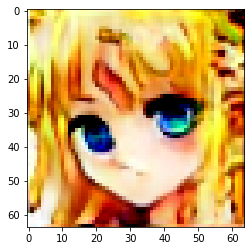

In [22]:
import math
z = torch.randn(16, 512).to(device)
step = int(math.log(64, 2)) - 2
out = G(z, step=step)
print(out[1]-out[0])
plt.imshow(out[0].permute([1,2,0]).detach().cpu().numpy())
p = D(out)

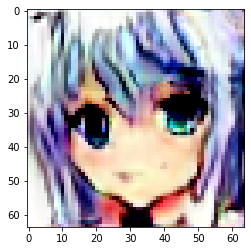

In [23]:
plt.imshow(out[p.argmax()].permute([1,2,0]).detach().cpu().numpy())

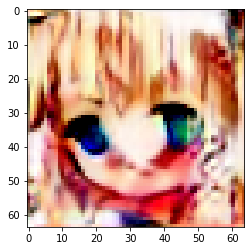

In [24]:
plt.imshow(out[1].permute([1,2,0]).detach().cpu().numpy())

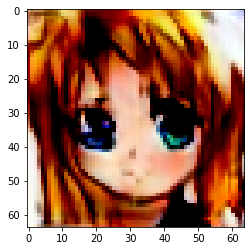

In [25]:
plt.imshow(fake[0].permute([1,2,0]).detach().cpu().numpy())

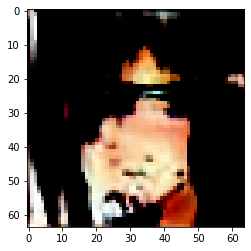

In [26]:
plt.imshow(fake[D(fake.to(device)).argmax()].permute([1,2,0]).detach().cpu().numpy())

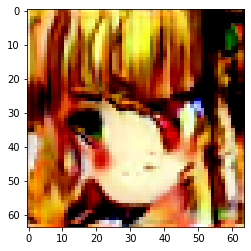

In [27]:
plt.imshow(fake[1].permute([1,2,0]).detach().cpu().numpy())

In [28]:
torch.save(G, "Generator.pth")
torch.save(D, "Discriminator.pth")